In [1]:
library(circlize)
library(ComplexHeatmap)
library(data.table)

circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))


Loading required package: grid

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This mess

In [2]:
trans_dir = "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/from_wei/trans_CD4_NC_tophits_multianno/"
trans_files = paste0(trans_dir,list.files(trans_dir))
head(trans_files,2)

[1] "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/from_wei/trans_CD4_NC_tophits_multianno/A1BG_CD4_NC_count_gw_allchr.txt_result.tophits.annovar.txt.hg19_multianno.txt"           
[2] "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/from_wei/trans_CD4_NC_tophits_multianno/A1BG_CD4_NC_count_gw_allchr.txt_result.tophits.annovar.txt.hg19_multianno.txt.merged.txt"

In [3]:
# Manual pruning of "independent" SNPs based on distance

dist = 500000
for (myfile in trans_files){
    df = fread(myfile)
    df = unique(df)
    df_list = list()
    to_include_snps = c()
    for (chrom in unique(df$Chr)){
        snps = df[df$Chr==chrom,"Start"]$Start
        if (length(snps)==1){chrom_snps = snps}
        else {
            chrom_snps = snps[1]
            for (i in 2:length(snps)){
                snp = snps[i]
                mydist = snp-chrom_snps[length(chrom_snps)]
                if (mydist>dist){chrom_snps = c(chrom_snps, snp)}
            }
        }
        to_include_snps = c(to_include_snps,chrom_snps)
        df_list[[chrom]] = df[df$Chr==chrom & df$Start %in% to_include_snps, ]
    }
    df_new = rbindlist(df_list)
    out_file = paste0(myfile,".merged.txt")
    fwrite(df_new, out_file)
}

In [4]:
gene_locs_file = "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/GeneLocations.tsv"
gene_loc = fread(gene_locs_file)
head(gene_loc)

gene_name,gene_id,seqid,start,end,strand
<chr>,<chr>,<chr>,<int>,<int>,<chr>
AL627309.1,ENSG00000237683,1,134901,139379,-
AL669831.1,ENSG00000269831,1,738532,739137,-
AL645608.2,ENSG00000269308,1,818043,819983,+
AL645608.1,ENSG00000268179,1,861264,866445,-
AL645728.1,ENSG00000215014,1,1510355,1511373,+
AL590822.2,ENSG00000269554,1,2121237,2123179,+


In [5]:
gene_files = list.files(trans_dir, pattern=".merged.txt")
length(gene_files)
head(gene_files,2)

[1] 12783

[1] "A1BG_CD4_NC_count_gw_allchr.txt_result.tophits.annovar.txt.hg19_multianno.txt.merged.txt"
[2] "A2M_CD4_NC_count_gw_allchr.txt_result.tophits.annovar.txt.hg19_multianno.txt.merged.txt"

In [6]:
genes = gsub("_CD4_NC_count_gw_allchr.txt_result.tophits.annovar.txt.hg19_multianno.txt.merged.txt", "", gene_files)
length(genes)
head(genes)

[1] 12783

[1] "A1BG"  "A2M"   "AAAS"  "AACS"  "AAED1" "AAGAB"

In [7]:
df_list = list()
for (i in 1:length(genes)){
    gene = genes[i]
    chrom = gene_loc[gene_loc$gene_name == gene,"seqid"]$seqid[1]
    file = paste0(trans_dir,gene_files[i])
    df = fread(file)
    if (nrow(df)==0){next}
    colnames(df)[(ncol(df)-2):ncol(df)] <- c("p.value","neg.log10.p.value","cis.trans")
    colnames(df)[1:5] <- paste0("snp_",colnames(df)[1:5])
    df$gene_chr = chrom
    df$gene = gene
    df_list[[gene]] = df
}
df_combine = rbindlist(df_list)

In [8]:
nrow(df_combine)
head(df_combine)

[1] 50908

snp_Chr,snp_Start,snp_End,snp_Ref,snp_Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene,⋯,phyloP7way_vertebrate,phyloP20way_mammalian,phastCons7way_vertebrate,phastCons20way_mammalian,SiPhy_29way_logOdds,p.value,neg.log10.p.value,cis.trans,gene_chr,gene
<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
11,17000242,17000242,C,T,intronic,PLEKHA7,,NA,NA,⋯,NA,NA,NA,NA,NA,7.72457e-07,6.112126,potential_novel,19,A1BG
19,16410530,16410530,C,T,intergenic,AP1M1;KLF2,dist=53816;dist=25107,NA,NA,⋯,NA,NA,NA,NA,NA,1.45986e-08,7.835689,potential_novel,19,A1BG
19,58826534,58826534,A,G,ncRNA_exonic,ERVK3-1;ZNF8-ERVK3-1,,NA,NA,⋯,NA,NA,NA,NA,NA,5.72771e-07,6.242019,known,19,A1BG
2,29820933,29820933,A,G,intronic,ALK,,NA,NA,⋯,NA,NA,NA,NA,NA,4.91610e-06,5.308379,potential_novel,12,A2M
6,37755546,37755546,G,C,intergenic,MDGA1;ZFAND3,dist=89887;dist=31957,NA,NA,⋯,NA,NA,NA,NA,NA,4.88554e-06,5.311087,potential_novel,12,A2M
8,32584857,32584857,A,G,intronic,NRG1,,NA,NA,⋯,NA,NA,NA,NA,NA,2.13832e-06,5.669927,potential_novel,12,A2M


In [9]:
# create a matrix, SNP chromosome by gene chromosome
mat=as.matrix(table(df_combine$snp_Chr, df_combine$gene_chr))
# add "chr" to chromosome names
rownames(mat) = paste0("chr",rownames(mat))
colnames(mat) = paste0("chr",colnames(mat))
# sort chromosomes from 1 to 22
mat = mat[paste0("chr",1:22),paste0("chr",1:22)]

In [10]:
max(mat)

[1] 698

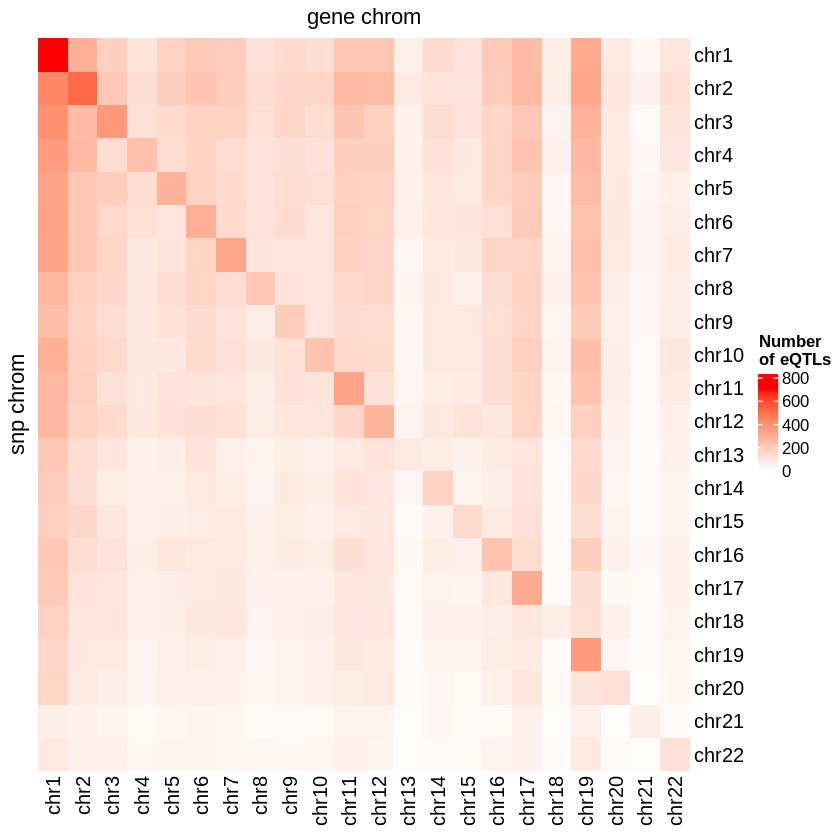

In [11]:
# all results (cis + trans)
col_fun = colorRamp2(c(0, max(mat)), c("white", "red"))
Heatmap(mat, cluster_rows = FALSE, cluster_columns = FALSE, name = "Number \nof eQTLs", 
        row_title = "snp chrom", column_title = "gene chrom", col=col_fun)

In [12]:
fig_dir <- "/share/ScratchGeneral/anncuo/OneK1K/saige_eqtl/ms_figures/"
pdf(paste0(fig_dir,"CD4_NC_trans_cis_heatmap.pdf"), width=10, height=10)
Heatmap(mat, cluster_rows = FALSE, cluster_columns = FALSE, name = "Number \nof eQTLs", 
        row_title = "snp chrom", column_title = "gene chrom", col=col_fun)
dev.off()

png 
  2

In [13]:
# trans only
df_combine_trans_only = df_combine[df_combine$cis.trans == "potential_novel"]
mat_trans=as.matrix(table(df_combine_trans_only$snp_Chr, df_combine_trans_only$gene_chr))
rownames(mat_trans) = paste0("chr",rownames(mat_trans))
colnames(mat_trans) = paste0("chr",colnames(mat_trans))
mat_trans = mat_trans[paste0("chr",1:22),paste0("chr",1:22)]

In [14]:
max(mat_trans)

[1] 427

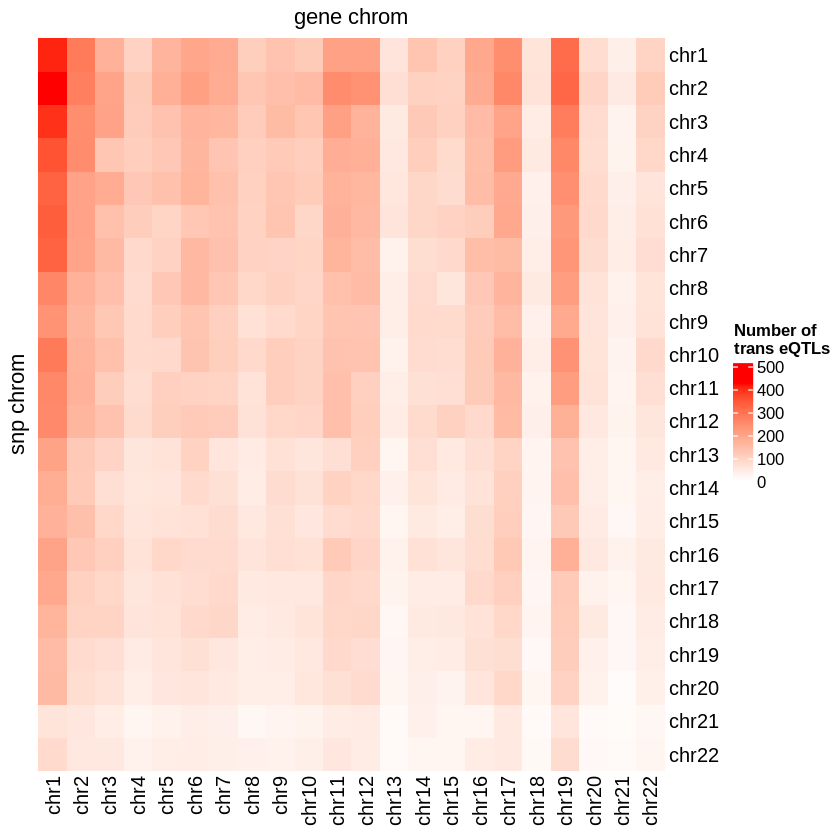

In [15]:
col_fun = colorRamp2(c(0, max(mat_trans)), c("white", "red"))
Heatmap(mat_trans, cluster_rows = FALSE, cluster_columns = FALSE, name = "Number of \ntrans eQTLs", 
        row_title = "snp chrom", column_title = "gene chrom", col=col_fun)

In [16]:
fig_dir <- "/share/ScratchGeneral/anncuo/OneK1K/saige_eqtl/ms_figures/"
pdf(paste0(fig_dir,"CD4_NC_trans_only_heatmap.pdf"), width=10, height=10)
Heatmap(mat_trans, cluster_rows = FALSE, cluster_columns = FALSE, name = "Number of \ntrans eQTLs", 
        row_title = "snp chrom", column_title = "gene chrom", col=col_fun)
dev.off()

png 
  2